In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import azureml.core
from azureml.core import Workspace

# check core SDK version number, note AML Python SDK 1.30 or above is required for this sample notebook
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.31.0


In [2]:
# Load workspace configuration
ws = Workspace.from_config()
print(ws.name, ws.location, ws.resource_group, ws.subscription_id, sep='\t')

aia-arc-aks-aml-ws	eastus	aia-arc-aml-ws-rg	ce859648-30e1-4135-9d0f-8358aebfe789


In [3]:
experiment_name = 'Tutorial-sklearn-mnist-arc'

from azureml.core import Experiment
exp = Experiment(workspace=ws, name=experiment_name)

We see:
![Experiment](https://i.imgur.com/NGY2iSi.png)

In [4]:
from azureml.core.compute import KubernetesCompute
from azureml.core.compute import ComputeTarget
import os

# choose a name for your Azure Arc-enabled Kubernetes compute
amlarc_compute_name = os.environ.get("AML_COMPUTE_CLUSTER_NAME", "arc")

if amlarc_compute_name in ws.compute_targets:
    amlarc_compute = ws.compute_targets[amlarc_compute_name]
    if amlarc_compute and type(amlarc_compute) is KubernetesCompute:
        print("found compute target: " + amlarc_compute_name)
else:
    print("do this manually...")
    # ... 

Class KubernetesCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class KubernetesCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.


found compute target: arc


In [5]:
from azureml.core import Dataset
from azureml.opendatasets import MNIST

data_folder = os.path.join(os.getcwd(), 'data')
os.makedirs(data_folder, exist_ok=True)

mnist_file_dataset = MNIST.get_file_dataset()
mnist_file_dataset.download(data_folder, overwrite=True)

mnist_file_dataset = mnist_file_dataset.register(workspace=ws,
                                                 name='mnist_opendataset',
                                                 description='training and test dataset',
                                                 create_new_version=True)

We see:
![Dataset](https://i.imgur.com/GwX3O2a.png)

And:
![Dataset](https://i.imgur.com/SPNAF5S.png)

In [6]:
ls data/https%3A/%2Fazureopendatastorage.azurefd.net/mnist/

t10k-images-idx3-ubyte.gz*  train-images-idx3-ubyte.gz*
t10k-labels-idx1-ubyte.gz*  train-labels-idx1-ubyte.gz*


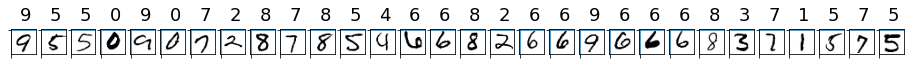

In [7]:
# make sure utils.py is in the same directory as this code
from utils import load_data
import glob

# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the model converge faster.
X_train = load_data(glob.glob(os.path.join(data_folder,"**/train-images-idx3-ubyte.gz"), recursive=True)[0], False) / 255.0
X_test = load_data(glob.glob(os.path.join(data_folder,"**/t10k-images-idx3-ubyte.gz"), recursive=True)[0], False) / 255.0
y_train = load_data(glob.glob(os.path.join(data_folder,"**/train-labels-idx1-ubyte.gz"), recursive=True)[0], True).reshape(-1)
y_test = load_data(glob.glob(os.path.join(data_folder,"**/t10k-labels-idx1-ubyte.gz"), recursive=True)[0], True).reshape(-1)

# now let's show some randomly chosen images from the traininng set.
count = 0
sample_size = 30
plt.figure(figsize = (16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x=10, y=-10, s=y_train[i], fontsize=18)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.Greys)
plt.show()

# Training specs

In [8]:
import os
script_folder = os.path.join(os.getcwd(), "sklearn-mnist-arc")
os.makedirs(script_folder, exist_ok=True)

In [9]:
%%writefile $script_folder/train.py

import argparse
import os
import numpy as np
import glob

from sklearn.linear_model import LogisticRegression
import joblib

from azureml.core import Run
from utils import load_data

# let user feed in 2 parameters, the dataset to mount or download, and the regularization rate of the logistic regression model
parser = argparse.ArgumentParser()
parser.add_argument('--data-folder', type=str, dest='data_folder', help='data folder mounting point')
parser.add_argument('--regularization', type=float, dest='reg', default=0.01, help='regularization rate')
args = parser.parse_args()

data_folder = args.data_folder
print('Data folder:', data_folder)

# load train and test set into numpy arrays
# note we scale the pixel intensity values to 0-1 (by dividing it with 255.0) so the model can converge faster.
X_train = load_data(glob.glob(os.path.join(data_folder, '**/train-images-idx3-ubyte.gz'), recursive=True)[0], False) / 255.0
X_test = load_data(glob.glob(os.path.join(data_folder, '**/t10k-images-idx3-ubyte.gz'), recursive=True)[0], False) / 255.0
y_train = load_data(glob.glob(os.path.join(data_folder, '**/train-labels-idx1-ubyte.gz'), recursive=True)[0], True).reshape(-1)
y_test = load_data(glob.glob(os.path.join(data_folder, '**/t10k-labels-idx1-ubyte.gz'), recursive=True)[0], True).reshape(-1)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, sep = '\n')

# get hold of the current run
run = Run.get_context()

print('Train a logistic regression model with regularization rate of', args.reg)
clf = LogisticRegression(C=1.0/args.reg, solver="liblinear", multi_class="auto", random_state=42)
clf.fit(X_train, y_train)

print('Predict the test set')
y_hat = clf.predict(X_test)

# calculate accuracy on the prediction
acc = np.average(y_hat == y_test)
print('Accuracy is', acc)

run.log('regularization rate', np.float(args.reg))
run.log('accuracy', np.float(acc))

os.makedirs('outputs', exist_ok=True)
# note file saved in the outputs folder is automatically uploaded into experiment record
joblib.dump(value=clf, filename='outputs/sklearn_mnist_model.pkl')

Overwriting /mnt/batch/tasks/shared/LS_root/mounts/clusters/mdrrahman1/code/Users/mdrrahman/arcdemo1/sklearn-mnist-arc/train.py


In [10]:
import shutil
shutil.copy('utils.py', script_folder)

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/mdrrahman1/code/Users/mdrrahman/arcdemo1/sklearn-mnist-arc/utils.py'

We see:
![New folder and training](https://i.imgur.com/DvA8FVZ.png)

# Connect to Arc now

In [11]:
from azureml.core.environment import Environment
from azureml.core.conda_dependencies import CondaDependencies

# to install required packages
env = Environment('arc-training-env')
cd = CondaDependencies.create(pip_packages=['azureml-dataset-runtime[pandas,fuse]', 'azureml-defaults'], conda_packages = ['scikit-learn==0.22.1'])

env.python.conda_dependencies = cd

# Register environment to re-use later
env.register(workspace = ws)

{
    "databricks": {
        "eggLibraries": [],
        "jarLibraries": [],
        "mavenLibraries": [],
        "pypiLibraries": [],
        "rcranLibraries": []
    },
    "docker": {
        "arguments": [],
        "baseDockerfile": null,
        "baseImage": "mcr.microsoft.com/azureml/openmpi3.1.2-ubuntu18.04:20210531.v1",
        "baseImageRegistry": {
            "address": null,
            "password": null,
            "registryIdentity": null,
            "username": null
        },
        "enabled": false,
        "platform": {
            "architecture": "amd64",
            "os": "Linux"
        },
        "sharedVolumes": true,
        "shmSize": null
    },
    "environmentVariables": {
        "EXAMPLE_ENV_VAR": "EXAMPLE_VALUE"
    },
    "inferencingStackVersion": null,
    "name": "arc-training-env",
    "python": {
        "baseCondaEnvironment": null,
        "condaDependencies": {
            "channels": [
                "anaconda",
                "conda-forg

In [12]:
from azureml.core import ScriptRunConfig

args = ['--data-folder', mnist_file_dataset.as_mount(), '--regularization', 0.5]

src = ScriptRunConfig(source_directory=script_folder,
                      script='train.py', 
                      arguments=args,
                      compute_target=amlarc_compute,
                      environment=env)

In [13]:
run = exp.submit(config=src)
run

Experiment,Id,Type,Status,Details Page,Docs Page
Tutorial-sklearn-mnist-arc,Tutorial-sklearn-mnist-arc_1626959741_57706634,azureml.scriptrun,Starting,Link to Azure Machine Learning studio,Link to Documentation


We see:
![Run 1](https://i.imgur.com/vhI67L5.png)

Image build logs:
![Image build](https://i.imgur.com/rhG3br2.png)

Container build:
![Container build](https://i.imgur.com/OpevDVP.png)

Goes into queued:
![Job stage](https://i.imgur.com/6IK2gmE.png)

In [14]:
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

Class KubernetesCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class KubernetesCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class KubernetesCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class KubernetesCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class KubernetesCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class KubernetesCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class KubernetesCompute: This is an experimental class, and may change at any time. Plea

In [15]:
# specify show_output to True for a verbose log
run.wait_for_completion(show_output=True)

RunId: Tutorial-sklearn-mnist-arc_1626959741_57706634
Web View: https://ml.azure.com/runs/Tutorial-sklearn-mnist-arc_1626959741_57706634?wsid=/subscriptions/ce859648-30e1-4135-9d0f-8358aebfe789/resourcegroups/aia-arc-aml-ws-rg/workspaces/aia-arc-aks-aml-ws&tid=72f988bf-86f1-41af-91ab-2d7cd011db47

Execution Summary
RunId: Tutorial-sklearn-mnist-arc_1626959741_57706634
Web View: https://ml.azure.com/runs/Tutorial-sklearn-mnist-arc_1626959741_57706634?wsid=/subscriptions/ce859648-30e1-4135-9d0f-8358aebfe789/resourcegroups/aia-arc-aml-ws-rg/workspaces/aia-arc-aks-aml-ws&tid=72f988bf-86f1-41af-91ab-2d7cd011db47



{'runId': 'Tutorial-sklearn-mnist-arc_1626959741_57706634',
 'target': 'arc',
 'status': 'Completed',
 'startTimeUtc': '2021-07-22T13:18:05.846496Z',
 'endTimeUtc': '2021-07-22T13:20:37.105039Z',
 'properties': {'_azureml.ComputeTargetType': 'kubernetes',
  'ContentSnapshotId': 'ac47ff6d-57c5-4a61-b596-d52215c05ada',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json',
  'JobType': 'RegularJob',
  'GpuCount': '0',
  'Cluster': 'Arc-Data-AKS'},
 'inputDatasets': [{'dataset': {'id': 'bb1def71-0161-40d9-92b5-7b86482cd68e'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'input__bb1def71', 'mechanism': 'Mount'}}],
 'outputDatasets': [],
 'runDefinition': {'script': 'train.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': ['--data-folder',
   'DatasetConsumptionConfig:input__bb1def71',
   '--regularization',
   '0.5'],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  

In [16]:
print(run.get_metrics())

{'regularization rate': 0.5, 'accuracy': 0.9193}


Class KubernetesCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class KubernetesCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.


In [17]:
print(run.get_file_names())

['azureml-logs/55_azureml-execution-tvmps_a98dbfd3bbbc0386035172c25d5cc150-master-0_d.txt', 'azureml-logs/65_job_prep-tvmps_a98dbfd3bbbc0386035172c25d5cc150-master-0_d.txt', 'azureml-logs/70_driver_log.txt', 'azureml-logs/75_job_post-tvmps_a98dbfd3bbbc0386035172c25d5cc150-master-0_d.txt', 'azureml-logs/azureml/job_log_agent.log.a98dbfd3bbbc0386035172c25d5cc150-master-0', 'logs/azureml/dataprep/backgroundProcess.log', 'logs/azureml/dataprep/backgroundProcess_Telemetry.log', 'logs/azureml/job_prep_azureml.log', 'logs/azureml/job_release_azureml.log', 'logs/azureml/master0_670_azureml.log', 'outputs/sklearn_mnist_model.pkl']


Class KubernetesCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class KubernetesCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class KubernetesCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.


![Run results](https://i.imgur.com/j2A8Qt2.png)

In [18]:
# register model 
model = run.register_model(model_name='sklearn_mnist', model_path='outputs/sklearn_mnist_model.pkl')
print(model.name, model.id, model.version, sep='\t')

sklearn_mnist	sklearn_mnist:1	1


Class KubernetesCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class KubernetesCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class KubernetesCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.


![New model](https://i.imgur.com/e1F2Oah.png)